In [1]:
!pip install lifelines
!pip install osqp==0.5
!pip install scikit-survival
!pip install pycox
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 12.0 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=79aad783a36d1372a57c6d9aac642c922945a663e1fe04a77513f5262ecacc81
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.0/209.0 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for osqp: filename=osqp-0.5.0-cp310-cp310-linux_x86_64.whl size=195605 sha256=3cd757f2f8af646c8a5f362422effd181b942e67de0e152ec502b0f069085d4e
  Stored in 

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as opt
from torch.distributions.weibull import Weibull
from torch.distributions.log_normal import LogNormal
from torch.distributions.categorical import Categorical
from torch.distributions.mixture_same_family import MixtureSameFamily
from torch.distributions import constraints
from torch.distributions.exp_family import ExponentialFamily
from torch.distributions.utils import _standard_normal, broadcast_all
import math
from numbers import Real
from numbers import Number
from einops import rearrange
import pandas as pd
import numpy as np
import scipy.stats as ss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lifelines.utils import concordance_index# as c_index
from sksurv.metrics import brier_score, integrated_brier_score, concordance_index_censored as ci_scikit
from copy import copy, deepcopy
import dask
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
'''torch.cuda.set_device(0)
torch.backends.cudnn.benchmark = True'''

Mounted at /content/drive


'torch.cuda.set_device(0)\ntorch.backends.cudnn.benchmark = True'

In [2]:
def non_censored_diagn(data, E, T, mlt, step):
    errors, churned = [], np.where(E)[0]
    bins = np.arange(min(T.iloc[churned]), max(T.iloc[churned]), step)
    for i in range(len(bins)-1):
        idx = data_test.loc[(data[event_column]==1) & (data[time_column]>=bins[i]) & (data[time_column]<=bins[i+1])].index.values
        errors.append(mean_absolute_error(T_test.iloc[idx], mlt[idx]))
    fig = make_subplots(rows=3, cols=1)
    # Add traces
    fig.append_trace(go.Scatter(x=T.iloc[churned].index, y=T.iloc[churned], mode='markers', name='TRUE'), row=1, col=1)
    fig.append_trace(go.Scatter(x=T.iloc[churned].index, y=mlt[churned], mode='markers', name='PRED'), row=1, col=1)
    fig.append_trace(go.Scatter(x=T.iloc[churned].index, y=np.abs(T.iloc[churned] - mlt[churned]), mode='lines', name='ERROS'), row=1, col=1)
    fig.append_trace(go.Scatter(x=[0, max(T.iloc[churned].index)], y=[mean_absolute_error(T.iloc[churned], mlt[churned])]*2, mode='lines', name='MAE'), row=1, col=1)
    fig.append_trace(go.Scatter(x=[0, max(T.iloc[churned].index)], y=[np.median(np.abs(T.iloc[churned] - mlt[churned]))]*2, mode='lines', name='MEDIAN'), row=1, col=1)
    fig.append_trace(go.Histogram(x=np.abs(T.iloc[churned] - mlt[churned]), histnorm='probability'), row=2, col=1)
    fig.append_trace(go.Scatter(x=bins[1:], y=errors), row=3, col=1)
    fig.update_layout(height=750)
    return fig

def plot_surv(idx, T, mlt, surv, times, vs=0.05):
    rows, cols, k = int(np.ceil(len(idx)/3)), 3, 0
    subplot_titles = ['Survival curve of '+str(c) for c in idx]
    surv_plot = make_subplots(rows=rows, cols=cols, shared_yaxes=True, subplot_titles=subplot_titles, horizontal_spacing = 0.01, vertical_spacing=vs)
    for i in range(rows):
        for j in range(cols):
          surv_plot.add_trace(go.Scatter(x=times, y=surv[:,idx[k]].flatten(), name=str(idx[k]), line=dict(color='#0000ff')), row=i+1, col=j+1)
          surv_plot.add_trace(go.Scatter(x=[T[idx[k]]]*10, y=np.linspace(0,1,10), mode='lines', line=dict(color='#ff0000')), row=i + 1, col=j + 1)
          surv_plot.add_trace(go.Scatter(x=[mlt[idx[k]]] * 10, y=np.linspace(0, 1, 10), mode='lines', line=dict(color='#00ff00')), row=i + 1, col=j + 1)
          k += 1
          if k >= len(idx):
            break
    surv_plot.update_layout(height=rows*300)
    return surv_plot

In [3]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/survival analysis/credit_card_churn/BankChurners.csv')
df

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.999910
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.999940
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.999980
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.999870
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.999980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,...,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462,0.000191,0.999810
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,...,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511,0.995270,0.004729
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,...,5409.0,0,5409.0,0.819,10291,60,0.818,0.000,0.997880,0.002118
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,...,5281.0,0,5281.0,0.535,8395,62,0.722,0.000,0.996710,0.003294


In [4]:
pd.DataFrame({'Dtype': df.dtypes, 'Nunique': df.nunique(), 'Isnull': df.isnull().sum()}, index=df.columns)

,Dtype,Nunique,Isnull
CLIENTNUM,int64,10127,0
Attrition_Flag,object,2,0
Customer_Age,int64,45,0
Gender,object,2,0
Dependent_count,int64,6,0
Education_Level,object,7,0
Marital_Status,object,4,0
Income_Category,object,6,0
Card_Category,object,4,0
Months_on_book,int64,44,0


In [5]:
df.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894,0.159997,0.840003
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691,0.365301,0.365301
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000,0.000008,0.000420
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000,0.000099,0.999660
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000,0.000181,0.999820
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000,0.000337,0.999900
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000,0.999580,0.999990


In [4]:
time_column = 'Months_on_book'
event_column = 'Attrition_Flag'
to_remove = ['CLIENTNUM', 'Avg_Open_To_Buy', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 
          'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']
features = [c for c in df.columns if (c not in [time_column, event_column]) and (c not in to_remove)]
categorical = [c for c in features if (df[c].dtype=='object') and (df[c].nunique() > 2)]
binary = [c for c in features if df[c].nunique() == 2]
numerical = [col for col in features if col not in categorical + binary]
df[numerical] = df[numerical].apply(pd.to_numeric,1)
df[time_column] = df[time_column]+0.1
df = df.replace({event_column: {'Existing Customer': 0, 'Attrited Customer': 1}})

fig = make_subplots(rows=1, cols=3, horizontal_spacing = 0.03, subplot_titles=('Event Distribution', 'Time Distribution', "Features Correlation"))
fig.append_trace(go.Histogram(x=df[event_column]), row=1, col=1)
fig.append_trace(go.Histogram(x=df[time_column]), row=1, col=2)
fig.append_trace(go.Heatmap(z=df[numerical].corr(),x=numerical,y=numerical), row=1, col=3)
fig.show()

In [5]:
# Creating the X, T and E inputs
data_train, data_test = train_test_split(df,test_size=0.2, stratify=df[event_column], random_state=42)
data_valid, data_test = train_test_split(data_test, test_size=0.5, stratify=data_test[event_column], random_state=42)
data_train, data_valid, data_test = data_train.reset_index( drop = True ), data_valid.reset_index( drop = True ), data_test.reset_index( drop = True )
X_train, X_valid, X_test = data_train[features], data_valid[features], data_test[features]
T_train, T_valid, T_test = data_train[time_column], data_valid[time_column], data_test[time_column]
E_train, E_valid, E_test = data_train[event_column], data_valid[event_column], data_test[event_column]

cat_enc_d = {}
for cat in categorical+binary:
    print(cat)
    LE = LabelEncoder()
    X_train[cat] = LE.fit_transform(X_train[cat])
    X_valid[cat] = LE.transform(X_valid[cat])
    X_test[cat] = LE.transform(X_test[cat])
    cat_enc_d[cat] = LE
 
MS = MinMaxScaler(feature_range=(0, 1))
scaled_train = MS.fit_transform(X_train[numerical])
scaled_valid = MS.transform(X_valid[numerical])
scaled_test = MS.transform(X_test[numerical])
X_train[numerical], X_valid[numerical], X_test[numerical] = scaled_train, scaled_valid, scaled_test

X_train.shape, X_valid.shape, X_test.shape

Education_Level
Marital_Status
Income_Category
Card_Category
Gender


<ipython-input-5-b0db0d61e588>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-b0db0d61e588>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-b0db0d61e588>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-b0db0d61

((8101, 17), (1013, 17), (1013, 17))

In [10]:
X_train

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0.212766,0,0.0,6,1,4,0,0.6,0.500000,0.333333,0.034213,0.885975,0.201943,0.070140,0.248062,0.120625,0.872362
1,0.382979,1,0.6,3,2,2,3,0.8,0.333333,0.500000,0.720658,0.000000,0.249926,0.100315,0.217054,0.156974,0.000000
2,0.425532,1,0.4,3,1,3,0,1.0,0.500000,0.166667,0.309323,0.363528,0.262585,0.214543,0.612403,0.229941,0.078392
3,0.212766,0,0.4,2,1,4,0,0.4,0.166667,0.500000,0.050962,0.632896,0.255814,0.064243,0.240310,0.098815,0.512563
4,0.510638,1,0.2,2,2,0,0,0.6,0.333333,0.500000,1.000000,0.470799,0.213424,0.191469,0.480620,0.192246,0.034171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8096,0.425532,0,0.8,3,1,5,0,0.4,0.166667,0.500000,0.133948,0.000000,0.250810,0.261838,0.565891,0.227248,0.000000
8097,0.553191,0,0.2,3,1,4,0,0.0,0.500000,0.500000,0.015742,0.406039,0.229614,0.418952,0.426357,0.230749,0.524623
8098,0.744681,0,0.0,2,2,1,0,0.4,0.500000,0.666667,0.250401,0.000000,0.243156,0.099055,0.279070,0.269251,0.000000
8099,0.361702,0,0.6,2,1,4,0,1.0,0.333333,0.166667,0.038899,1.000000,0.141890,0.223304,0.434109,0.186322,0.928643


In [23]:
from torch import autograd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def sinc(x):
    x = x * np.pi
    return torch.where(x != 0., torch.sin(x) / x, 1.)

class LogLogistic(ExponentialFamily):
    arg_constraints = {'scale': constraints.positive}
    support = constraints.positive
    #has_rsample = True

    @property
    def mean(self):
        mean = torch.exp(self.loc) / sinc(self.scale)
        return torch.where(self.scale > 1., np.nan, mean).to(device)

    @property
    def variance(self):
        variance = torch.exp(2 * self.loc) * (1. / sinc(2 * self.scale) - 1. / sinc(self.scale)**2)
        return torch.where(self.scale > 0.5, np.nan, variance)

    def __init__(self, loc, scale, validate_args=None):
        self.loc, self.scale = broadcast_all(loc, scale)
        if isinstance(loc, Number) and isinstance(scale, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.loc.size()
        super(LogLogistic, self).__init__(batch_shape, validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(LogLogistic, _instance)
        batch_shape = torch.Size(batch_shape)
        new.loc = self.loc.expand(batch_shape)
        new.scale = self.scale.expand(batch_shape)
        super(LogLogistic, new).__init__(batch_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new

    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return ((value.log() - self.loc)/self.scale) - self.scale.log() - value.log() - 2*torch.log(1+torch.exp((value.log() - self.loc)/self.scale))

    def cdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return 1/(1+torch.exp(-(value.log() - self.loc)/self.scale))
 
class SURV_DATA_LOADER(Dataset):
    def __init__(self, X, T, E, numerical_col, categorical_col):
        self.X1, self.X2, self.T, self.E = X[numerical_col].values.astype(np.float32), X[categorical_col].values, T.astype(np.float32), E.astype(np.bool)
 
    def __len__(self):
        return len(self.E)
 
    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.T[idx], self.E[idx]

class Embedder(nn.Module):
    def __init__(self, vocab_size, dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, dim)

    def forward(self, x):
        return self.embeddings(x)

class NNModel(nn.Module):
    def __init__(self, input_shape, units=None, factors=None, activ=True, norm=True, dropout=False, slops=None):
        super().__init__()
        self.input_shape = input_shape
        self.units = units
        self.factors = factors
        self.activ, self.norm = activ, norm
        self.network = nn.ModuleList()
        if self.factors:
            self.units = np.round(self.input_shape * np.asarray(self.factors)).astype(int)
        if self.units is not None:
            self.dropout = np.zeros_like(self.units) if not dropout else dropout
            self.slops = np.full(len(self.units), 1) if slops is None else slops
            for i, j, k in zip(self.units, self.dropout, self.slops):
                if i >= 1:
                    block = self.__build_block__(input_shape, i, p=j, slop=k)
                    self.network.extend(block)
                    input_shape = i
        self.output_shape = input_shape
        self.reset_parameters()
    
    def __build_block__(self, input_shape, units, p, slop):
        block = []
        block.append(nn.Linear(input_shape, units, bias=not self.norm))
        if self.norm:
            #block.append(nn.BatchNorm1d(units))
            block.append(nn.LayerNorm(units, eps=1e-5))
        if self.activ:
            #block.append(nn.ELU(slop))
            #block.append(nn.GELU())
            block.append(nn.Mish())
        if p > 0:
            block.append(nn.Dropout(p))
        return block
 
    def forward(self, x):
        for layer in self.network:
          tmp = layer(x)
          x = tmp
        return x
 
    def reset_parameters(self):
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                #layer.bias.data.fill_(0.1)
 
 
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=None):
        """
        Implementation of multi-head attention layer of the original transformer model.
        einsum and einops.rearrange is used whenever possible
        Args:
            dim: token's dimension, i.e. word embedding vector size
            heads: the number of distinct representations to learn
            dim_head: the dim of the head. In general dim_head<dim.
            However, it may not necessary be (dim/heads)
        """
        super().__init__()
        self.dim_head = (int(dim / heads)) if dim_head is None else dim_head
        _dim = self.dim_head * heads
        self.heads = heads
        self.to_qvk = nn.Linear(dim, _dim * 3, bias=False)
        self.W_0 = nn.Linear( _dim, dim, bias=False)
        self.scale_factor = self.dim_head ** -0.5
    def forward(self, x, mask=None):
        assert x.dim() == 3
        # Step 1
        qkv = self.to_qvk(x)  # [batch, tokens, dim*3*heads ]
        # Step 2
        # decomposition to q,v,k and cast to tuple
        # the resulted shape before casting to tuple will be:
        # [3, batch, heads, tokens, dim_head]
        q, k, v = tuple(rearrange(qkv, 'b t (d k h) -> k b h t d ', k=3, h=self.heads))
        # Step 3
        # resulted shape will be: [batch, heads, tokens, tokens]
        scaled_dot_prod = torch.einsum('b h i d , b h j d -> b h i j', q, k) * self.scale_factor
        if mask is not None:
            assert mask.shape == scaled_dot_prod.shape[2:]
            scaled_dot_prod = scaled_dot_prod.masked_fill(mask, -np.inf)
        attention = torch.softmax(scaled_dot_prod, dim=-1)
        # Step 4. Calc result per batch and per head h
        out = torch.einsum('b h i j , b h j d -> b h i d', attention, v)
        # Step 5. Re-compose: merge heads with dim_head d
        out = rearrange(out, "b h t d -> b t (h d)")
        # Step 6. Apply final linear transformation layer
        return self.W_0(out)

class TransformerBlock(nn.Module):
   """
   Vanilla transformer block from the original paper "Attention is all you need"
   Detailed analysis: https://theaisummer.com/transformer/
   """
   def __init__(self, dim, heads=8, dim_head=None, dim_linear_block=1024, dropout=0.1):
       """
       Args:
           dim: token's vector length
           heads: number of heads
           dim_head: if none dim/heads is used
           dim_linear_block: the inner projection dim
           dropout: probability of droppping values
       """
       super().__init__()
       self.mhsa = MultiHeadSelfAttention(dim=dim, heads=heads, dim_head=dim_head)
       self.drop = nn.Dropout(dropout)
       self.norm_1 = nn.LayerNorm(dim)
       self.norm_2 = nn.LayerNorm(dim)
       #self.linear = NNModel(dim, units=[dim_linear_block, dim], factors=None, dropout=[dropout, dropout], norm=False)
       self.linear = nn.Sequential(
           nn.Linear(dim, dim_linear_block), nn.ReLU(), nn.Dropout(dropout),
           nn.Linear(dim_linear_block, dim), nn.Dropout(dropout)
       )
   def forward(self, x, mask=None):
       y = self.norm_1(self.drop(self.mhsa(x, mask)) + x)
       return self.norm_2(self.linear(y) + y)

class Transformer(nn.Module):
    def __init__(self, blocks, dim, heads=8, dim_head=None, dim_linear_block=1024, dropout=0.1):
       super().__init__()
       self.block_list = [TransformerBlock(dim, heads, dim_head, dim_linear_block=dim_linear_block, dropout=dropout) for _ in range(blocks)]
       self.layers = nn.ModuleList(self.block_list)

    def forward(self, x, mask=None):
       for layer in self.layers:
           x = layer(x, mask)
       return x

class TabTransformer(nn.Module):
    def __init__(self, categories, numerical_nb, blocks, dim, mlp_units, heads=8, dim_head=None, dim_linear_block=1024, dropout=0.1, mlp_dropout=0.00001, apply_pos=False):
        """
        categories: tuple containing the number of unique values within each category
        """
        super().__init__()
        self.embed = Embedder(sum(categories), dim)
        #self.cont_embed = nn.ModuleList([NNModel(1, units=[dim], factors=None, norm=False) for i in range(numerical_nb)])
        self.cont_embed = NNModel(numerical_nb, units=[dim], factors=None, norm=False, activ=False)
        self.transformer = Transformer(blocks, dim, heads, dim_head, dim_linear_block, dropout)
        #self.input_size = dim * (len(categories) + numerical_nb) + numerical_nb
        self.input_size = dim * (len(categories) + 1) + numerical_nb
        self.mlp = NNModel(self.input_size, units=mlp_units, factors=None, dropout=[mlp_dropout]*len(mlp_units))
        self.norm = nn.LayerNorm(numerical_nb)
        self.output_shape = mlp_units[-1]
        self.apply_pos = apply_pos

    def forward(self, x_cont, x_cat):
        #x = torch.stack([e(x_cont[:,[i]]) for i,e in enumerate(self.cont_embed)], 1)#[batch_shape, num_cont, dim]
        x1_ = self.cont_embed(x_cont)#[batch_shape, dim]
        x = torch.unsqueeze(x1_, 1)
        if x_cat.nelement() != 0: #skipped if there's no categorical feature
            x2 = self.embed(x_cat)#[batch_shape, num_cat, dim]
            #x = torch.cat((x, x2), 1)#[batch_shape, num_cat+num_cont, dim]
            x = torch.cat((x, x2), 1)#[batch_shape, num_cat+1, dim]
        x = self.pe(x) if self.apply_pos else x
        x = self.transformer(x)
        x = x.flatten(1)
        x = torch.cat((x, self.norm(x_cont)), dim = -1)
        return self.mlp(x)

class MDN(nn.Module):
    def __init__(self, shared, clf_nn, alpha_nn, beta_nn, n_comp):
        super(MDN, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.shared = shared
        self.clf_nn = clf_nn
        self.alpha_nn = alpha_nn
        self.beta_nn = beta_nn
        self.n_comp = n_comp
        self.pi = nn.Linear(self.clf_nn.output_shape, self.n_comp) if self.n_comp > 1 else None
        self.ai = nn.Linear(self.alpha_nn.output_shape, self.n_comp)
        self.bi = nn.Linear(self.beta_nn.output_shape, self.n_comp)
 
    def forward(self, x_cont, x_cat):
        x = self.shared(x_cont, x_cat)
        proba = self.proba_model(x) if self.n_comp > 1 else torch.ones((len(x),1)).to(self.device)
        alpha = self.alpha_model(x)
        beta = self.beta_model(x)
        return proba, alpha, beta
 
    def proba_model(self, x):
        model = self.clf_nn(x)
        model = self.pi(model)
        model = nn.Softmax(dim=-1)(model)
        return model
 
    def alpha_model(self, x):
        model = self.alpha_nn(x)
        model = self.ai(model)
        return model
 
    def beta_model(self, x):
        model = self.beta_nn(x)
        model = self.bi(model)
        return model

class BaseParametric:
    def __init__(self, model, num_time_bins, numerical_col, categorical_col, resume=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.losses = {'Epoch': [], 'Train': [], 'Test': [], 'BState': [], 'LState': [], 'LR': []}
        self.num_time_bins = num_time_bins
        self.numerical_col, self.categorical_col = numerical_col, categorical_col
        self.times = None
        self.optim = resume
 
    def train_model(self, optim, train_loader, grad_clip, l2_reg):
          total_loss = 0
          self.model = self.model.train()
        #with autograd.detect_anomaly():
          for i, (X1, X2, T, E) in enumerate(train_loader):
              X1, X2, T, E = X1.to(self.device), X2.to(self.device), T.to(self.device), E.to(self.device)
              #self.model.get_weight()
              self.optim.zero_grad()
              loss = self.loss_function(X1, X2, T, E, l2_reg)
              loss.backward()
              torch.nn.utils.clip_grad_norm_(self.model.parameters(), grad_clip)
              self.optim.step()
              '''self.model.get_grad()
              print('_'*50)'''
              total_loss += loss.item()
          return total_loss/(i+1)
        
 
    def eval_model(self, test_loader):
        self.model = self.model.eval()
        total_loss = 0
        for i, (X1, X2, T, E) in enumerate(test_loader):
            X1, X2, T, E = X1.to(self.device), X2.to(self.device), T.to(self.device), E.to(self.device)
            loss = self.loss_function(X1, X2, T, E, l2_reg=0)
            total_loss += loss.item()
        return total_loss/(i+1)#np.abs(-100. - total_loss)
 
 
    def fit(self, X_train, T_train, E_train, epoch, lr, opt_kwarg, batch_size=None,  grad_clip=100, momentum=0.9, is_min_time_zero=False, extra_pct_time=0.1,
            X_test=None, T_test=None, E_test=None, l2_reg=0, eval=True, verbose=True, save=True):
        
        min_t = 0 if is_min_time_zero else min(T_train)
        max_t = max(T_train)*(1+extra_pct_time)
        self.times = np.linspace(min_t, max_t, self.num_time_bins)
 
        batch_size = len(X_train) if batch_size is None else batch_size
        #X_train_uncens, Y_train_uncens, T_train_uncens, X_train_cens, Y_train_cens, T_train_cens = self.process_data(X_train, T_train, E_train)
        train_load = DataLoader(SURV_DATA_LOADER(X_train, T_train, E_train, self.numerical_col, self.categorical_col), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        if X_test is not None:
            #X_test_uncens, Y_test_uncens, T_test_uncens, X_test_cens, Y_test_cens, T_test_cens = self.process_data(X_test, T_test, E_test)
            test_load = DataLoader(SURV_DATA_LOADER(X_test, T_test, E_test, self.numerical_col, self.categorical_col), batch_size=batch_size, shuffle=True)  # DATALOADER obj
 
        best_loss = 1e100
        #self.optim = opt.Adam(self.model.parameters(), lr=lr)
        self.optim = opt.SGD(self.model.parameters(), lr=lr, momentum=momentum, nesterov=True)

        #scheduler = None
        #scheduler = opt.lr_scheduler.CyclicLR(self.optim, **opt_kwarg)
        scheduler = opt.lr_scheduler.ReduceLROnPlateau(self.optim, **opt_kwarg)
        #scheduler = opt.lr_scheduler.MultiStepLR(self.optim, milestones=[28, 120], gamma=0.1)

        eval_score = ''
        for i in range(epoch):
            if verbose:
                print('##### EPOCH ' + str(i) + ' #####')
               
            train_loss = self.train_model(self.optim, train_load, grad_clip, l2_reg)
            self.losses['LState'] = deepcopy(self.model.state_dict())
    
            if verbose:
                print('train loss : ', train_loss)
            self.losses['Epoch'].append(i), self.losses['Train'].append(train_loss)
    
            if X_test is not None:
                valid_loss = self.eval_model(test_load)

                if verbose:
                    print('test loss : ', valid_loss)
                self.losses['Test'].append(valid_loss)
    
                if scheduler is not None:
                    scheduler.step(valid_loss)
                    self.losses['LR'].append(self.optim.param_groups[0]['lr'])
                    '''scheduler.step()
                    self.losses['LR'].append(scheduler.get_last_lr()[0])'''
    
                if valid_loss < best_loss:
                    self.losses['BState'] = deepcopy(self.model.state_dict())
                    best_loss = valid_loss
                    print('===========SAVE===========')
                    
 
    def b_index(self, X_train, T_train, E_train, X_test, T_test, E_test, survival, plot=True):
        time_idx = self.times[np.argmin(self.times<min(T_test)):np.argmax(self.times>max(T_test)) - 1] #don't keep times index that are beyond max(T_train)
        train_e_t = np.asarray(list(zip(E_train.astype(np.bool), T_train)), dtype='|bool, i4') #concat event and time
        test_e_t = np.asarray(list(zip(E_test.astype(np.bool), T_test)), dtype='|bool, i4')
        brier_res = []
        for j, i in enumerate(time_idx):
            _, score = brier_score(train_e_t, test_e_t, survival[:,j], i)
            brier_res.append(score[0])
        ibs = np.trapz(brier_res, time_idx)/max(T_train)
        if plot:
            figure = self.plot_brier_curve(time_idx, brier_res, ibs)
            return brier_res, ibs, figure
        else:
            return brier_res, ibs

    def c_index(self, mlt, t, e):
        #mlt = torch.sum(p * alpha * torch.lgamma(1 + (1/beta)).exp(), 1).cpu().data.numpy() #WEIBULL
        #mlt = torch.sum(p * torch.exp(alpha + torch.pow(beta, 2)/2), 1).data.numpy() #LOGNORMAL
        res = 1 - ci_scikit(e.astype(np.bool), t, mlt)[0]
        return res
 
    def plot_brier_curve(self, time_axis, score, ibs):
        fig, ax = plt.subplots(figsize=(8, 4))
        plt.plot(time_axis, score, color='blue', label='Brier score / time', lw=2)
 
        plt.axhline(y=0.25, color='black', linestyle='-')
        #ax.annotate('0.25', xy=(1, 0.5), xytext=(t, 0.5), fontsize=12)
 
        title = "Integrated Brier Score: " + str(ibs)
        plt.legend(fontsize=12)
        plt.title(title, fontsize=15)
        plt.ylim(0, 1.05)
        return plt

    def feature_importance(self, rep, X_test, T_test, E_test, batch_size=None):
        res = np.zeros((rep, X_test.shape[1]))
        batch_size = len(X_train) if batch_size is None else batch_size
        test_load = DataLoader(SURV_DATA_LOADER(X_test, T_test, E_test, self.numerical_col, self.categorical_col), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        base_loss = self.eval_model(test_load)
        origin = X_test.copy()
        for i, col in enumerate(X_test.columns):
            for j in range(rep):
                X_test.loc[:,col] = np.random.permutation(X_test.loc[:, col])
                test_load = DataLoader(SURV_DATA_LOADER(X_test, T_test, E_test, self.numerical_col, self.categorical_col), batch_size=batch_size, shuffle=True)  # DATALOADER obj
                loss = self.eval_model(test_load)
                res[j, i] = base_loss - loss
                X_test = origin
        res = np.abs(res)
        return {'importances': res, 'importances_mean': np.mean(res, 0), 'importances_std': np.std(res, 0)}

class WeibullModel(BaseParametric):
    def __init__(self, model, num_time_bins, numerical_col, categorical_col,resume=None):
        super(WeibullModel, self).__init__(model, num_time_bins, numerical_col, categorical_col,)

    def loss_function(self, X1, X2, T, E, l2_reg):
        pi, alpha, beta = self.model(X1, X2)
        alpha = nn.ELU()(alpha) + 1 + 1e-15 #WEIBULL
        beta = nn.ELU()(beta) + 2 #WEIBULL
        mix = Categorical(pi)
        comp = Weibull(alpha, beta, validate_args=None)
        mixture = MixtureSameFamily(mix, comp)
        loss = torch.where(E, mixture.log_prob(T), torch.log(torch.clamp(1 - mixture.cdf(T), min=1e-25)))
        loss = -torch.mean(loss)
        return loss

    def prdict_survival(self, X):
        self.model.eval()
        X1 = torch.tensor(X[self.numerical_col].values.astype(np.float32)).to(self.device)
        X2 = torch.tensor(X[self.categorical_col].values).to(self.device)
        T = (torch.FloatTensor(self.times[:,np.newaxis,np.newaxis].astype(np.float32)) + 1e-5).to(self.device)
        pi, alpha, beta = self.model(X1, X2)
        alpha = nn.ELU()(alpha) + 1 + 1e-15 #WEIBULL
        beta = nn.ELU()(beta) + 2 #WEIBULL
        mix = Categorical(pi)
        comp = Weibull(alpha, beta, validate_args=None)
        mixture = MixtureSameFamily(mix, comp)
        surv = 1 - mixture.cdf(T)
        return pi, alpha, beta, surv, mixture.mean

class LogNormalModel(BaseParametric):
    def __init__(self, model, num_time_bins, numerical_col, categorical_col,resume=None):
        super(LogNormalModel, self).__init__(model, num_time_bins, numerical_col, categorical_col,)

    def loss_function(self, X1, X2, T, E, l2_reg):
        pi, mu, std = self.model(X1, X2)
        std = nn.ELU()(std) + 1 + 1e-15 #LOGNORMAL
        mix = Categorical(pi)
        comp = LogNormal(mu, std, validate_args=None)
        mixture = MixtureSameFamily(mix, comp)
        loss = torch.where(E, mixture.log_prob(T), torch.log(torch.clamp(1 - mixture.cdf(T), min=1e-25)))
        loss = -torch.mean(loss)
        return loss

    def prdict_survival(self, X):
        self.model.eval()
        X1 = torch.tensor(X[self.numerical_col].values.astype(np.float32)).to(self.device)
        X2 = torch.tensor(X[self.categorical_col].values).to(self.device)
        T = (torch.FloatTensor(self.times[:,np.newaxis,np.newaxis].astype(np.float32)) + 1e-5).to(self.device)
        pi, mu, std = self.model(X1, X2)
        std = nn.ELU()(std) + 1 + 1e-15 #LOGNORMAL
        mix = Categorical(pi)
        comp = LogNormal(mu, std, validate_args=None)
        mixture = MixtureSameFamily(mix, comp)
        surv = 1 - mixture.cdf(T)
        return pi, mu, std, surv, mixture.mean

class LogLogisticModel(BaseParametric):
    def __init__(self, model, num_time_bins, numerical_col, categorical_col,resume=None):
        super(LogLogisticModel, self).__init__(model, num_time_bins, numerical_col, categorical_col,)

    def loss_function(self, X1, X2, T, E, l2_reg):
        pi, mu, std = self.model(X1, X2)
        mu = torch.where(mu>0, torch.tanh(mu), mu)
        std = ((1 - torch.exp(-torch.sigmoid(std))) * 0.5) #MAKE STD BETWEEN 0 AND 0.5
        mix = Categorical(pi)
        comp = LogLogistic(mu, std, validate_args=None)
        mixture = MixtureSameFamily(mix, comp)
        loss = torch.where(E, mixture.log_prob(T), torch.log(torch.clamp(1 - mixture.cdf(T), min=1e-25)))
        loss = -torch.mean(loss)
        return loss

    def prdict_survival(self, X):
        self.model.eval()
        X1 = torch.tensor(X[self.numerical_col].values.astype(np.float32)).to(self.device)
        X2 = torch.tensor(X[self.categorical_col].values).to(self.device)
        T = (torch.FloatTensor(self.times[:,np.newaxis,np.newaxis].astype(np.float32)) + 1e-5).to(self.device)
        pi, mu, std = self.model(X1, X2)
        mu = torch.where(mu>0, torch.tanh(mu), mu)
        std = ((1 - torch.exp(-torch.sigmoid(std))) * 0.5) #MAKE STD BETWEEN 0 AND 0.5
        mix = Categorical(pi)
        comp = LogLogistic(mu, std, validate_args=None)
        mixture = MixtureSameFamily(mix, comp)
        surv = 1 - mixture.cdf(T)
        return pi, mu, std, surv, mixture.mean
 
def gradient_clipper(model: nn.Module, val: float) -> nn.Module:
    def process_grad(grad):
        grad[grad != grad] = 1e-10
        return torch.clamp(grad, -val, val)
    for parameter in model.parameters():
        parameter.register_hook(lambda grad: process_grad(grad))
    
    return model

In [24]:
n_comp, epoch, lr, batch_size, d, mlp_d = 3, 50000, 1e-2, 4096, 1e-6, 1e-6
cyclic_kwarg = {'base_lr': lr, 'max_lr': 1e-2, 'step_size_up':250, 'step_size_down':250}
plateau_kwarg = {'factor':0.5, 'patience':200, 'verbose':True, 'min_lr':1e-7, 'mode':'min'}

categories = list(X_train[categorical+binary].nunique())
shared_nn = TabTransformer(categories, len(numerical), blocks=4, dim=64, mlp_units=[512], heads=8, dim_head=None, dim_linear_block=1024, dropout=d, mlp_dropout=mlp_d)
clf_nn = NNModel(shared_nn.output_shape , units=[128], factors=None, dropout=[mlp_d])
alpha_nn = NNModel(shared_nn.output_shape, units=[128], factors=None, dropout=[mlp_d])
beta_nn = NNModel(shared_nn.output_shape, units=[128], factors=None, dropout=[mlp_d])#, dropout=[d,d,d,d]

nn_model = gradient_clipper(MDN(shared_nn, clf_nn, alpha_nn, beta_nn, n_comp), 10)
#nn_model.load_state_dict(best_state)
print(nn_model)
print(sum(p.numel() for p in nn_model.parameters() if p.requires_grad))
dws = LogNormalModel(nn_model, int(T_train.max()*1.5), numerical, categorical+binary)
dws.fit(X_train, T_train.values, E_train.values, epoch, lr, plateau_kwarg, batch_size=batch_size, grad_clip=10, momentum=0.9,
        X_test=X_valid, T_test=T_valid.values, E_test=E_valid.values, l2_reg=0, eval=False, verbose=True, is_min_time_zero=True, extra_pct_time=0.5)

MDN(
  (shared): TabTransformer(
    (embed): Embedder(
      (embeddings): Embedding(23, 64)
    )
    (cont_embed): NNModel(
      (network): ModuleList(
        (0): Linear(in_features=12, out_features=64, bias=True)
      )
    )
    (transformer): Transformer(
      (layers): ModuleList(
        (0-3): 4 x TransformerBlock(
          (mhsa): MultiHeadSelfAttention(
            (to_qvk): Linear(in_features=64, out_features=192, bias=False)
            (W_0): Linear(in_features=64, out_features=64, bias=False)
          )
          (drop): Dropout(p=1e-06, inplace=False)
          (norm_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (linear): Sequential(
            (0): Linear(in_features=64, out_features=1024, bias=True)
            (1): ReLU()
            (2): Dropout(p=1e-06, inplace=False)
            (3): Linear(in_features=1024, out_features=64, bias=True)
            (4): Dropout(p=1

<ipython-input-24-3b32a8032eab>:14: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

<ipython-input-23-c7d615ea55e8>:53: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

<ipython-input-23-c7d615ea55e8>:53: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1

Streaming output truncated to the last 5000 lines.
test loss :  1.6473079919815063
##### EPOCH 263 #####
train loss :  1.1545110642910004
test loss :  0.7366048693656921
##### EPOCH 264 #####
train loss :  0.7251531779766083
test loss :  0.7422359585762024
##### EPOCH 265 #####
train loss :  0.7331609725952148
test loss :  0.7449815273284912
##### EPOCH 266 #####
train loss :  0.7338062226772308
test loss :  0.7392740249633789
##### EPOCH 267 #####
train loss :  0.7256201207637787
test loss :  0.7295807003974915
##### EPOCH 268 #####
train loss :  0.7134446501731873
test loss :  0.7194728851318359
##### EPOCH 269 #####
train loss :  0.7022549211978912
test loss :  0.7185869216918945
##### EPOCH 270 #####
train loss :  0.696401983499527
test loss :  0.7253904342651367
##### EPOCH 271 #####
train loss :  0.7111145853996277
test loss :  0.9440494179725647
##### EPOCH 272 #####
train loss :  1.236790955066681
test loss :  0.9016590714454651
##### EPOCH 273 #####
train loss :  0.83951130509

KeyboardInterrupt: ignored

In [25]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

best_state = deepcopy(dws.losses['BState'])
dws.model.load_state_dict(best_state)
print(np.min(dws.losses['Test']))

fig = make_subplots(rows=3, cols=1)
s = 0
model = dws
fig.append_trace(go.Scatter(x=model.losses['Epoch'][s:], y=model.losses['Train'][s:],mode='lines',name='Train'), row=1, col=1)
fig.append_trace(go.Scatter(x=model.losses['Epoch'][s:], y=model.losses['Test'][s:],mode='lines',name='Test'), row=2, col=1)
fig.append_trace(go.Scatter(x=model.losses['Epoch'][s:], y=model.losses['LR'][s:],mode='lines',name='LR'), row=3, col=1)
fig.update_layout(height=1000, width=1500, title_text="Stacked Subplots")
fig.show()

0.6201500296592712


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning:

pylab import has clobbered these variables: ['figure', 'std', 'sinc', 'pi']
`%matplotlib` prevents importing * from pylab and numpy

<ipython-input-23-c7d615ea55e8>:358: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

<ipython-input-23-c7d615ea55e8>:359: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/rel

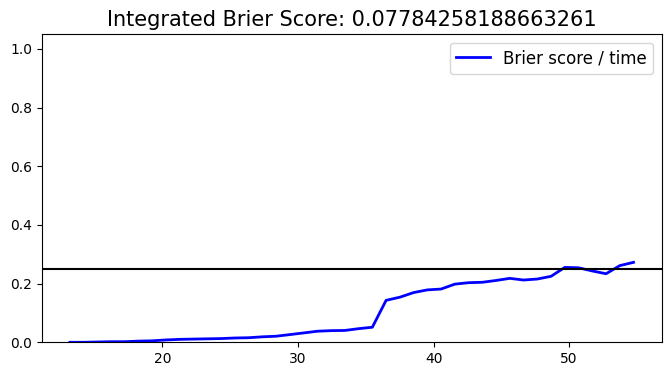

0.9130445898956842


<ipython-input-23-c7d615ea55e8>:374: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [26]:
from matplotlib import pyplot as plt
%pylab inline

pi, mu, std, survival_predictions, mlt = dws.prdict_survival(X_valid)
pi, mu, std, survival_predictions, mlt = pi.cpu(), mu.cpu(), std.cpu(), survival_predictions.cpu(), mlt.cpu().data.numpy()
survival_predictions = np.squeeze(survival_predictions.data.numpy())

brier_res, ibs, figure = dws.b_index(X_train.values, T_train, E_train.astype(float), X_valid.values, T_valid, E_valid.astype(float), survival_predictions.T, plot=True)
figure.show()
c_index = dws.c_index(mlt, T_valid, E_valid)
print(c_index)

<ipython-input-23-c7d615ea55e8>:358: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

<ipython-input-23-c7d615ea55e8>:359: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



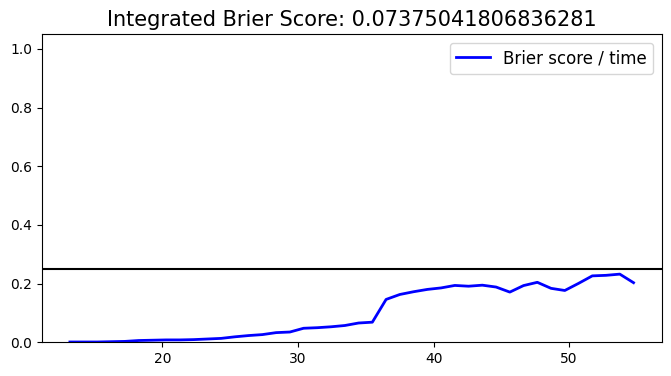

0.9254143963292228


<ipython-input-23-c7d615ea55e8>:374: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [27]:
pi, mu, std, survival_predictions, mlt = dws.prdict_survival(X_test)
pi, mu, std, survival_predictions, mlt = pi.cpu(), mu.cpu(), std.cpu(), survival_predictions.cpu(), mlt.cpu().data.numpy()
survival_predictions = np.squeeze(survival_predictions.data.numpy())

brier_res, ibs, figure = dws.b_index(X_train.values, T_train, E_train.astype(float), X_test.values, T_test, E_test.astype(float), survival_predictions.T, plot=True)
figure.show()
c_index = dws.c_index(mlt, T_test, E_test)
print(c_index)

In [28]:
non_censored_diagn(data_test, E_test, T_test, mlt, 5).show()

In [ ]:
pd.DataFrame(data={'Event': E_test, 'True': T_test, 'PRED': mlt})

,Event,True,PRED
0,False,4682.1,41256.308594
1,False,3583.1,6144.248535
2,False,4893.1,43076.183594
3,False,4750.1,44257.035156
4,False,4493.1,21833.337891
...,...,...,...
783,False,4899.1,21734.980469
784,True,4295.1,11869.456055
785,True,1087.1,11157.770508
786,False,4618.1,37374.941406


In [33]:
idx = data_test.loc[(data_test[event_column]==1) & (data_test[time_column]>=40) & (data_test[time_column]<=140)].index.values
plot_surv(idx, T_test, mlt, survival_predictions, dws.times, vs=0.01).show()

In [34]:
imp = dws.feature_importance(10, X_test, T_test, E_test, batch_size=None)
fig = go.Figure()
for i in range(X_test.shape[1]):
    fig.add_trace(go.Box(x=imp['importances'][:, i], name=X_test.columns[i]))
fig.show()

<ipython-input-23-c7d615ea55e8>:53: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

<ipython-input-23-c7d615ea55e8>:398: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-c7d615ea55e8>:53: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use

In [37]:
dws.model.cpu()
dws.model.state_dict()
torch.save(dws.model.state_dict(), '/content/drive/My Drive/Colab Notebooks/survival analysis/credit_card_churn/tabtransformer_lognormal.pth')